In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
# ncore = 48
# if ncore < mp.cpu_count():
ncore = mp.cpu_count()
ncore

256

# Workflow starts here!

In [4]:
###################### need to change start
ipts="30605"
###################### need to change end

## Find CT scan location

In [5]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['2023_06_11_sample2_fresh',
 '2023_05_23_sample1_fresh',
 '2023_06_12_sample4_fresh',
 '2023_06_12_sample3_fresh']

## Find OB location

In [6]:
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['2023_05_23_sample1_fresh', '2023_06_12']

## Find DC location

In [7]:
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2023_05_24']

In [8]:
###################### need to change start
sample_name = "2023_06_12_sample3_fresh"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2023_06_12")
dc_dir = os.path.join(dc_loc, "2023_05_24")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will *NOT* be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
###################### need to change end

# Load all data files (CT, OB and DC)

In [9]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 391 of angle 179.86
Found index of 0 degree projections: 0 of angle 0.0
Loading 783 CT projections...


783it [02:50,  4.59it/s]


783 CT projections loaded!
Shape: (783, 2048, 2048)
Loading 5 Open Beam (OB) images...


5it [00:00,  7.22it/s]


5 Open Beam (OB) images loaded!
Shape: (5, 2048, 2048)
Loading 5 Dark Current (DC) images...


5it [00:00,  6.91it/s]

5 Dark Current (DC) images loaded!
Shape: (5, 2048, 2048)


# Visual verification of loaded files

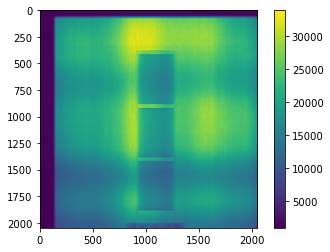

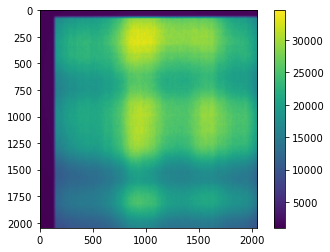

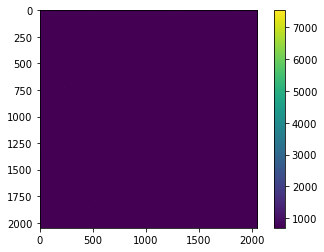

In [10]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


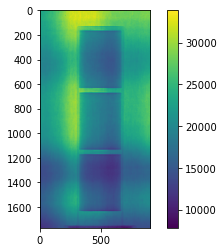

In [11]:
###################### need to change start
crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 600
crop_right = 1500
crop_top = 250
crop_bottom = 2020
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)
history_dict = rocku.log(history_dict, 'gamma_diff', gamma_diff)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Time: 5.178637334611267 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(783, 1770, 900)


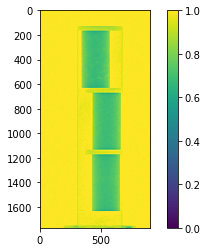

Time: 1.657402697019279 s


In [13]:
t0 = timeit.default_timer()
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

# Remove outliers again (optional)

t0 = timeit.default_timer()
proj_norm = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


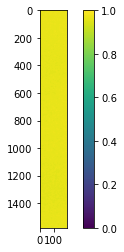

In [14]:
###################### need to change start
bg_left = 5
bg_right = 200
bg_top = 20
bg_bottom = 1600
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

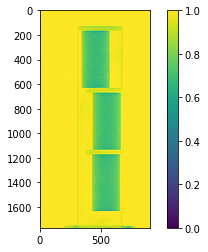

Time: 6.637972957920283 s


In [15]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
bg_roi_dict = {
    'left': bg_left,
    'right': bg_right,
    'top': bg_top,
    'bottom': bg_bottom
}
history_dict = rocku.log(history_dict, 'beam_fluc_corr', True)
history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi', bg_roi_dict)

# Minus log conversion

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

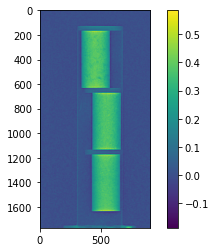

Time: 1.031536496244371 s


In [16]:
t0 = timeit.default_timer()
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'minus_log', True)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

# Remove outliers again (optional)

In [17]:
t0 = timeit.default_timer()
proj_mlog = tomopy.misc.corr.remove_outlier(proj_mlog, gamma_diff, ncore=ncore)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

Time: 2.2384622236713767 s


Error.  nthreads must be a positive integer

# Find and correct tilt

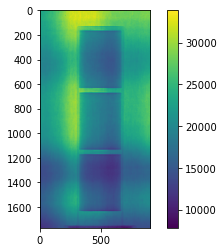

(1770, 900)

In [18]:
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
proj_crop_min.shape

Tilt correction ROI at 0 degree:


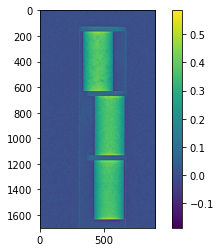

Tilt correction ROI at 180 degree (flipped):


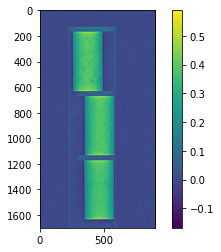

In [19]:
###################### need to change start
tt_left = 0
tt_right = 1500
tt_top = 0
tt_bottom = 1700
###################### need to change start
tt_roi_dict = {
    'left': tt_left,
    'right': tt_right,
    'top': tt_top,
    'bottom': tt_bottom
}
tt_000deg_mlog = proj_mlog[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_mlog = proj_mlog[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_000deg_trans = proj_norm[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_trans = proj_norm[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
print("Tilt correction ROI at 0 degree:")
# plt.imshow(tt_000deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_000deg_mlog)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree (flipped):")
# plt.imshow(tt_180deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(np.fliplr(tt_180deg_mlog))
plt.colorbar()
plt.show()

In [20]:
print("Finding the tilt angle using transmission images...")
t0 = timeit.default_timer()
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_trans, image180=tt_180deg_trans)
print("Found the tilt angle: ", tilt_ang.x)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Finding the tilt angle using transmission images...
Found the tilt angle:  -0.12984384324478426
Time: 7.339913104195148 s


In [21]:
print("Finding the tilt angle using minus log images...")
t0 = timeit.default_timer()
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_mlog, image180=tt_180deg_mlog)
print("Found the tilt angle: ", tilt_ang.x)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Finding the tilt angle using minus log images...
Found the tilt angle:  -0.13040655051635902
Time: 7.277282667346299 s


Projection at 0 degree:


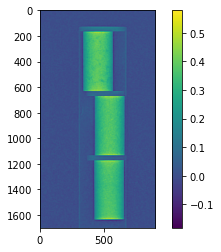

Projection at 180 degree (flipped):


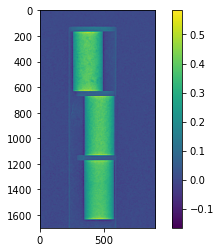

In [22]:
print("Projection at 0 degree:")
proj_mlog_tilt_000deg_mlog = tilt.apply_tilt_correction(tt_000deg_mlog, tilt_ang.x, ncore=ncore)
proj_mlog_tilt_180deg_mlog = tilt.apply_tilt_correction(tt_180deg_mlog, tilt_ang.x, ncore=ncore)
plt.imshow(proj_mlog_tilt_000deg_mlog)# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog_tilt_180deg_mlog))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [23]:
t0 = timeit.default_timer()
# tilt_ang.x = -0.7256422310429781
proj_mlog_tilt = proj_mlog[:]
for e_idx in range(proj_mlog.shape[0]):
    proj_mlog_tilt[e_idx] = tilt.apply_tilt_correction(proj_mlog[e_idx], tilt_ang.x, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'tilt_corr_roi', tt_roi_dict)
history_dict = rocku.log(history_dict, 'tilt_corr', tilt_ang.x)

Time cost 0.36464925873248527 min


# Ring Artifact Removal

Before ring removal:


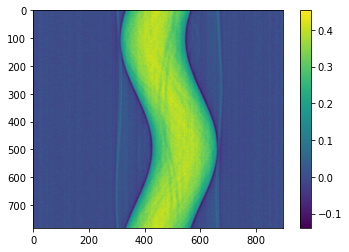

In [24]:
proj_mlog_rmv = None
slice_num = 500
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

In [31]:
# ring_algo = 'Vo' ######### (a) Vo's approach from tomopy (faster)
ring_algo = 'bm3d' ######### (b) bm3d approach (slow, but generally better)

#################################################################################
t0 = timeit.default_timer()
if ring_algo == 'Vo':
    # nchunk = int(proj_mlog.shape[0]/ncore) + 1
    # print("Chunk size: ", nchunk)
    proj_mlog_rmv = tomopy.remove_all_stripe(proj_mlog_tilt, 
                                             ncore=ncore, 
#                                              nchunk=nchunk
                                            )
if ring_algo == 'bm3d':
    print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
    proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
    print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
    proj_mlog_rmv = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', ring_algo)

Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.
Denoising sinogram 0
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 12
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 13
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 14
k: 4
k: 3


k: 3
k: 2
k: 1
k: 0
Denoising sinogram 167
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 168
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 169
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 170
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 171
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 172
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 173
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 174
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 175
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 176
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 177
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 178
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 179
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 180
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 181
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 182
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 183
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 184
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 185
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 186
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 338
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 339
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 340
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 341
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 342
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 343
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 344
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 345
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 346
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 347
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 348
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 349
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 350
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 351
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 352
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 353
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 354
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 355
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 356
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 357
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 509
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 510
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 511
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 512
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 513
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 514
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 515
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 516
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 517
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 518
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 519
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 520
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 521
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 522
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 523
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 524
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 525
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 526
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 527
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 528
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 680
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 681
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 682
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 683
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 684
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 685
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 686
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 687
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 688
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 689
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 690
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 691
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 692
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 693
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 694
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 695
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 696
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 697
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 698
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 699
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 851
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 852
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 853
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 854
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 855
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 856
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 857
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 858
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 859
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 860
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 861
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 862
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 863
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 864
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 865
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 866
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 867
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 868
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 869
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 870
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8

k: 0
Denoising sinogram 1021
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1022
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1023
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1024
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1025
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1026
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1027
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1028
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1029
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1030
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1031
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1032
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1033
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1034
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1035
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1036
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1037
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1038
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1039
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1040
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinog

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1189
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1190
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1191
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1192
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1193
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1194
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1195
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1196
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1197
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1198
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1199
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1200
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1201
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1202
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1203
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1204
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1205
k: 4
k: 3
k: 2
k: 0
Denoising sinogram 1206
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1207
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1208
k: 4
k: 3
k: 2
k: 1
k: 0
Denoi

k: 0
Denoising sinogram 1356
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1357
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1358
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1359
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1360
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1361
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1362
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1363
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1364
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1365
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1366
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1367
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1368
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1369
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1370
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1371
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1372
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1373
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1374
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1375
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinog

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1524
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1525
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1526
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1527
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1528
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1529
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1530
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1531
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1532
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1533
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1534
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1535
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1536
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1537
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1538
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1539
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1540
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1541
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1542
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1543
k: 4
k: 3
k: 2
k: 1
k: 0


k: 1
k: 0
Denoising sinogram 1691
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1692
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1693
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1694
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1695
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1696
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1697
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1698
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1699
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1700
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1701
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1702
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1703
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1704
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1705
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1706
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1707
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1708
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1709
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1710
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising 

Before ring removal:


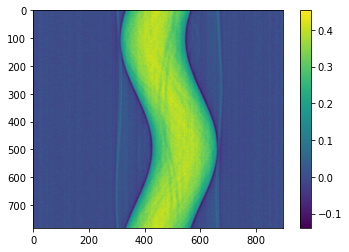

After ring removal:


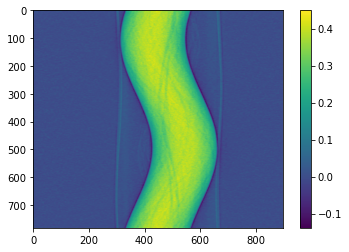

Difference:


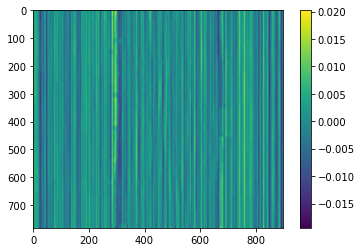

In [32]:
slice_num = 500
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [33]:
if proj_mlog_rmv is None:
    proj_mlog_to_recon = proj_mlog_tilt[:]
else:
    proj_mlog_to_recon = proj_mlog_rmv.astype(np.float32)
sino_norm = np.moveaxis(proj_norm, 1, 0)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

In [34]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog_to_recon[proj000_idx,:,:]), np.squeeze(proj_mlog_to_recon[proj180_idx,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 488.75


In [35]:
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center = calc.find_center_360(sino_mlog_to_recon[int(sino_mlog_to_recon.shape[0]/2)], win_width=800)[0]
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 487.56048583984375


# Reconstruction
## 1. Gridrec preview

Center of rotation 487.56048583984375
Time cost 0.002664616680704057 min


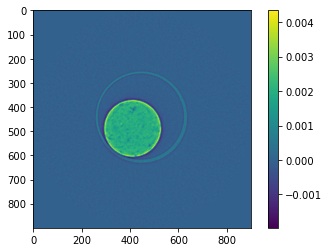

In [37]:
slice_idx = 200
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[slice_idx], rot_center, angles=ang_rad, apply_log=False,
                                      ratio=1.0,
                                      filter_name='shepp',
                                      pad=100,
                                      ncore=ncore
                                     )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 2. FBP preview

Center of rotation 500.8601608276367
Time cost 0.006614301819354296 min


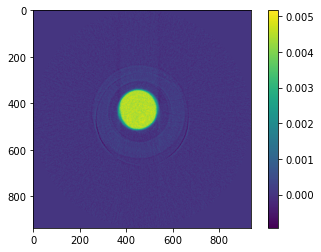

In [39]:
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.fbp_reconstruction(sino_mlog_to_recon[slice_idx], rot_center, angles=ang_rad, apply_log=False,
                                  ramp_win=None,
                                  filter_name='hann',
                                  pad=None,
                                  pad_mode='edge',
                                  ncore=ncore,
                                  gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                 )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 3. ASTRA preview

Center of rotation 472.37499237060547
Time cost 0.07203347848262638 min


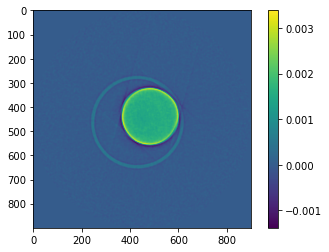

In [40]:
print("Center of rotation", rot_center)
# Reconstruction algorithms. 
# For CPU: 'FBP', 'SIRT', 'SART', 'ART', and CGLS'. 
# For GPU: 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', and 'CGLS_CUDA'.
t0 = timeit.default_timer()
rec_img1 = rec.astra_reconstruction(sino_mlog_to_recon[slice_idx], rot_center, angles=ang_rad, apply_log=False,
                                    method='SIRT_CUDA',
#                                     method='FBP_CUDA',
                                    ratio=1.0,
                                    filter_name='hann',
                                    pad=None,
                                    num_iter=300,
                                    ncore=ncore
                                   )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 4. svMBIR preview

Center of rotation 500.8601608276367
Calling multires_recon for axial size (rows,cols)=(468,468).
Calling multires_recon for axial size (rows,cols)=(234,234).
Reconstructing axial size (rows,cols)=(234,234).
Reconstructing axial size (rows,cols)=(468,468).
Reconstructing axial size (rows,cols)=(936,936).
Time cost 1.0741500866521771 min


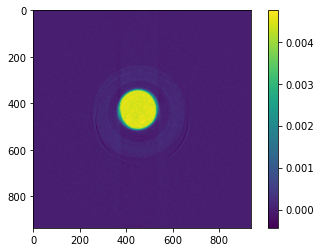

In [40]:
print("Center of rotation", rot_center)
T = 2.0
p = 1.2
sharpness = 0.0
snr_db = 30.0
center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
t0 = timeit.default_timer()
recon_mbir = svmbir.recon(proj_mlog_to_recon[:,slice_idx,:],
                          angles=np.array(ang_rad), # In radians
                          weight_type='transmission', 
                          center_offset=center_offset, 
                          snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                          positivity=False,
                          max_iterations=100,
                          num_threads= 112,
                          verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
                          svmbir_lib_path = "/netdisk/y9z/svmbir_cache",
                         )
recon_mbir = np.fliplr(np.rot90(recon_mbir, k=1, axes=(1,2)))
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(recon_mbir[0])
plt.colorbar()
plt.show()

## Pick one method to recon

In [38]:
pix_um = 42.7 # um
recon_algo = 'gridrec'
# recon_algo = 'svmbir'

##################################
t0 = timeit.default_timer()
####################### tomopy algorithms (gridrec and fbp are faster than algotom) ##########################
if recon_algo in ['art', 'bart', 'fbp', 'gridrec',
                  'mlem', 'osem', 'ospml_hybrid', 'ospml_quad',
                  'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh']:
    recon = tomopy.recon(proj_mlog_to_recon, ang_rad, center=rot_center,
                         algorithm=recon_algo,
                         ncore=ncore, 
#                          nchunk=nchunk
                        )
################################################ algotom algorithms ##########################################
    #### ASTRA
if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
    recon = rec.astra_reconstruction(proj_mlog_to_recon, rot_center, angles=ang_rad, apply_log=False,
                                     method=recon_algo,
                                     ratio=1.0,
                                     filter_name='hann',
                                     pad=None,
                                     num_iter=300,
                                     ncore=ncore
                                    )
    recon = np.moveaxis(recon, 1, 0) 
    #### gridrec from algotom
if recon_algo == 'gridrec_algo':
    recon = rec.gridrec_reconstruction(proj_mlog_to_recon, rot_center, angles=ang_rad, apply_log=False,
                                       ratio=1.0,
                                       filter_name='shepp',
                                       pad=100,
                                       ncore=ncore
                                      )
    recon = np.moveaxis(recon, 1, 0)
    #### FBP from algotom
if recon_algo == 'fbp_algo':
    recon = rec.fbp_reconstruction(proj_mlog_to_recon, rot_center, angles=ang_rad, apply_log=False,
                                   ramp_win=None,
                                   filter_name='hann',
                                   pad=None,
                                   pad_mode='edge',
                                   ncore=ncore,
                                   gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                  )
    recon = np.moveaxis(recon, 1, 0)
################################################### MBIR #####################################################
if recon_algo == 'svmbir':
    T = 2.0
    p = 1.2
    sharpness = 0.0
    snr_db = 30.0
    center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
    recon = svmbir.recon(
#         proj_mlog_to_recon,
        proj_mlog_to_recon[:,595:605,:],
        angles=np.array(ang_rad), # In radians
        weight_type='transmission', 
        center_offset=center_offset, 
        snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
        positivity=False,
        max_iterations=50,
        num_threads= 112,
        verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
        svmbir_lib_path = "/netdisk/y9z/svmbir_test",
    )
    recon = np.fliplr(np.rot90(recon, k=1, axes=(1,2)))
##################################
if pix_um is not None:
    pix_cm = pix_um/10000
    recon = recon/pix_cm
    history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
    recon_unit = "cm-1"
else:
    recon_unit = "px-1"
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Time cost 0.05950969724605481 min


# Crop recon

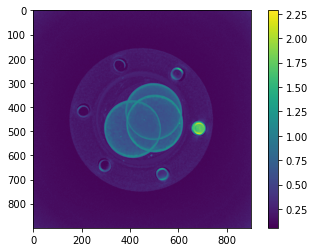

In [39]:
recon_max = np.max(recon, axis=0)
plt.imshow(recon_max)
plt.colorbar()
plt.show()

Recon ROI:


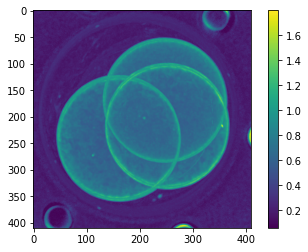

In [40]:
###################### need to change start
recon_crop = True
recon_crop_left = 250
recon_crop_right = 660
recon_crop_top = 250
recon_crop_bottom = 660
###################### need to change end
recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
recon_crop_roi_dict = {
    'left': recon_crop_left,
    'right': recon_crop_right,
    'top': recon_crop_top,
    'bottom': recon_crop_bottom
}
print("Recon ROI:")
plt.imshow(recon_max_crop)
plt.colorbar()
plt.show()

In [41]:
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
history_dict = rocku.log(history_dict, 'recon_crop', recon_crop)
if recon_crop:
    history_dict = rocku.log(history_dict, 'recon_crop_roi', recon_crop_roi_dict)

# If [Memory Issue], recon & save, *slice by slice*

In [ ]:
recon_algo = 'gridrec'
pix_um = None #um
save_to = None
#########################
if save_to is None:
    print("Input a location to save!")
else:
    t0 = timeit.default_timer()
    for h_idx in range(sino_mlog_to_recon.shape[0]):
        if recon_algo == 'gridrec':
            _rec_slice = rec.gridrec_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                    ncore=ncore
                                                   )
        if recon_algo == 'fbp':
            _rec_slice = rec.fbp_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                ncore=ncore,
                                                gpu=False,
    #                                             gpu=True, # Version error 7.8, current version 7.5
                                               )
        if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
            _rec_slice = rec.astra_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                  method=recon_algo,
                                                  num_iter=300,
                                                  ncore=ncore)
        if recon_algo == 'svmbir':
            T = 2.0
            p = 1.2
            sharpness = 0.0
            snr_db = 30.0
            center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
            _rec_mbir = svmbir.recon(proj_mlog_to_recon[:,h_idx,:],
                                      angles=np.array(ang_rad), # In radians
                                      weight_type='transmission', 
                                      center_offset=center_offset, 
                                      snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                                      positivity=False,
                                      max_iterations=100,
                                      num_threads= 112,
                                      verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
                                      svmbir_lib_path = "/netdisk/y9z/svmbir_test"
                                     )
            _rec_slice = np.flipud(np.rot90(_rec_mbir[0]))
        if pix_um is not None:
            pix_cm = pix_um/10000
            _rec_slice = _rec_slice/pix_cm
        _slice_name = save_to + "/recon_" + f'{h_idx:05d}'
        print('Saving {} ...'.format(_slice_name))
        dxchange.write_tiff(_rec_slice, fname=_slice_name, overwrite=True)
    if pix_um is not None:
        history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
        recon_unit = "cm-1"
    else:
        recon_unit = "px-1"
    history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
    t1 = timeit.default_timer()
    print("Time cost {} min".format((t1-t0)/60))

# Export recon files

In [42]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_all"
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name
save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

# Export to HDF5

In [43]:
history_dict

{'crop': True,
 'crop_roi': {'left': 600, 'right': 1500, 'top': 250, 'bottom': 2020},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 5, 'right': 200, 'top': 20, 'bottom': 1600},
 'minus_log': True,
 'tilt_corr_roi': {'left': 0, 'right': 1500, 'top': 0, 'bottom': 1700},
 'tilt_corr': -0.13040655051635902,
 'rot_center': 487.56048583984375,
 'ring_removal': 'bm3d',
 'pixel_size_um': 42.7,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'left': 250, 'right': 660, 'top': 250, 'bottom': 660}}

In [44]:
output_hdf5_dir = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
# output_hdf5_dir = "/netdisk/y9z/CG1D/IPTS-"+ipts+"/rockit/hdf5/"
# output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + sample_name + ".h5"

In [45]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=(recon_unit,))
    f.create_dataset('tomo/recon/recon_volume', data=recon)

In [46]:
os.listdir("/netdisk/y9z/IPTS-"+ ipts + "/hdf5")

['2023_06_11_sample2_fresh.h5',
 '2023_06_12_sample3_fresh.h5',
 '2023_05_23_sample1_fresh.h5']

In [47]:
os.listdir("/netdisk/y9z/IPTS-"+ ipts + "/recon")

['2023_06_11_sample2_fresh',
 '2023_05_23_sample1_fresh',
 '2023_06_12_sample3_fresh']